# LLama vs Alpaca CNN 

CNN capable of differentiating llamas and alpacas

## 1. Import Packages

In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

## 2. Process Images

### 2.1. Convert to png and rename photos

In [18]:
def convert_and_rename_photos(directory_origin, directory_destiny, base_name):
    # Get a list of all files in the directory_origin
    files = os.listdir(directory_origin)
    
    # Filter out only image files
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp','.webp'))]
    
    # Initialize a counter for renaming
    counter = 1
    
    # Loop through each image file
    for filename in image_files:
        # Open the image
        image_path = os.path.join(directory_origin, filename)
        with Image.open(image_path) as img:
            # Convert the image to PNG
            png_path = os.path.join(directory_destiny, f"{base_name}{counter}.png")
            img.save(png_path, "PNG")
        
        # Check if the destination file already exists
        if os.path.exists(png_path):
            # Delete the existing file
            os.remove(png_path)
        
        # Rename the file
        os.rename(image_path, png_path)
        
        # Increment the counter
        counter += 1

In [7]:
# Get the directory of the current script
current_dir = os.getcwd()

# Construct the absolute path to the file in 'dir0/dir1/dir3/'
origin_path = os.path.join(current_dir, '..', 'data/raw/alpaca')
destiny_path = os.path.join(current_dir, '..', 'data/processed')
base_name = "alpaca"

In [19]:
convert_and_rename_photos(origin_path,destiny_path, base_name)

In [20]:
origin_path = os.path.join(current_dir, '..', 'data/raw/llama')
destiny_path = os.path.join(current_dir, '..', 'data/processed')
base_name = "llama"

In [21]:
convert_and_rename_photos(origin_path,destiny_path, base_name)

### 2.2. Resize Images

In [22]:
def resize_images(directory, output_directory, target_size=(200, 200)):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Get a list of all files in the directory
    files = os.listdir(directory)
    
    # Filter out only image files
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    # Loop through each image file
    for filename in image_files:
        # Open the image
        image_path = os.path.join(directory, filename)
        with Image.open(image_path) as img:
            # Resize the image
            resized_img = img.resize(target_size)
            
            # Save the resized image to the output directory
            output_path = os.path.join(output_directory, filename)
            resized_img.save(output_path)

In [23]:
directory = os.path.join(current_dir, '..', 'data/processed')
output_directory = os.path.join(current_dir, '..', 'data/processed/resize')

In [24]:
resize_images(directory, output_directory)

### 2.3. Split into standard directories

In [25]:
# import packages
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

In [27]:
# create directories
dataset_home = os.path.join(current_dir, '..', 'data/processed/resize/')
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['llamas/', 'alpacas/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [54]:
import os
import random
from shutil import copyfile
def split_dataset(src_dir, dest_dir, train_ratio=0.75):
    # Create train and test directories
    train_dir = os.path.join(dest_dir, 'train')
    test_dir = os.path.join(dest_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Create alpacas and llamas directories in train and test directories
    for directory in ['alpacas', 'llamas']:
        os.makedirs(os.path.join(train_dir, directory), exist_ok=True)
        os.makedirs(os.path.join(test_dir, directory), exist_ok=True)
    
    # Loop through each file in the source directory
    for file in os.listdir(src_dir):
        src = os.path.join(src_dir, file)
        if file.startswith('alpaca'):
            dst_dir = os.path.join(train_dir, 'alpacas') if random.random() < train_ratio else os.path.join(test_dir, 'alpacas')
        elif file.startswith('llama'):
            dst_dir = os.path.join(train_dir, 'llamas') if random.random() < train_ratio else os.path.join(test_dir, 'llamas')
        
        # Copy the file to the appropriate train or test directory
        copyfile(src, os.path.join(dst_dir, file))

# Example usage:
src_directory = os.path.join(current_dir, '..', 'data/processed/resize')
dest_directory =os.path.join(current_dir, 'dataset')
split_dataset(src_directory, dest_directory)

## 3. Baseline CNN

In [8]:
# Import Packages
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD,Adam
from keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [107]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,loss=BinaryCrossentropy(),metrics=['accuracy'])
    return model

In [110]:
# define model
model = define_model()

In [65]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [60]:
# prepare iterators
train_it = datagen.flow_from_directory(os.path.join(current_dir, 'dataset/train'),
 class_mode='binary', batch_size=32, target_size=(200, 200))
test_it = datagen.flow_from_directory(os.path.join(current_dir, 'dataset/test'),
 class_mode='binary', batch_size=32, target_size=(200, 200))

Found 254 images belonging to 2 classes.
Found 117 images belonging to 2 classes.


In [111]:
# fit model
history = model.fit(
    train_it,
    steps_per_epoch=len(train_it),
    epochs=20,
    verbose=2
)

Epoch 1/20
8/8 - 33s - 4s/step - accuracy: 0.5000 - loss: 5.8317
Epoch 2/20
8/8 - 0s - 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20
8/8 - 7s - 842ms/step - accuracy: 0.6024 - loss: 1.4424
Epoch 4/20
8/8 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
8/8 - 5s - 687ms/step - accuracy: 0.6732 - loss: 0.6923
Epoch 6/20
8/8 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
8/8 - 6s - 714ms/step - accuracy: 0.7874 - loss: 0.4610
Epoch 8/20
8/8 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
8/8 - 6s - 707ms/step - accuracy: 0.8346 - loss: 0.4025
Epoch 10/20
8/8 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
8/8 - 5s - 685ms/step - accuracy: 0.8465 - loss: 0.3448
Epoch 12/20
8/8 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/20
8/8 - 6s - 720ms/step - accuracy: 0.8819 - loss: 0.2862
Epoch 14/20
8/8 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/20
8/8 

In [112]:
# Evaluate the model using the test data generator
evaluation = model.evaluate(
    test_it,  # Data generator for test/validation data
    steps=len(test_it),  # Number of steps (batches) to yield from the generator
    verbose=2  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

4/4 - 4s - 920ms/step - accuracy: 0.9487 - loss: 0.1843
Test Loss: 0.1843060851097107
Test Accuracy: 0.9487179517745972


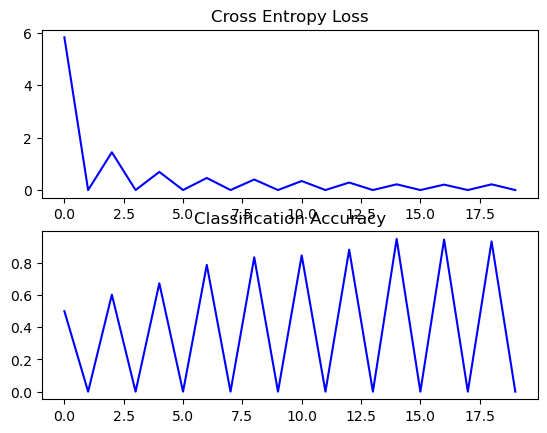

In [113]:
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.show
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')


In [114]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │    40,960,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,883,461 (468.76 MB)

 Trainable params: 40,961,153 (156.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,922,308 (312.51 MB)

## 4. Adding a Dropout Layer

In [124]:
def define_model_dropout():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))  # Dropout rate: 25%
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [125]:
from keras.layers import Dropout
model_d = define_model_dropout()

In [126]:
# fit model
history = model_d.fit(
    train_it,
    steps_per_epoch=len(train_it),
    epochs=20,
    verbose=2
)

Epoch 1/20
8/8 - 36s - 5s/step - accuracy: 0.4724 - loss: 9.2389
Epoch 2/20
8/8 - 0s - 17ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20
8/8 - 13s - 2s/step - accuracy: 0.5157 - loss: 2.8902
Epoch 4/20
8/8 - 0s - 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
8/8 - 6s - 748ms/step - accuracy: 0.5866 - loss: 1.2522
Epoch 6/20
8/8 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
8/8 - 6s - 742ms/step - accuracy: 0.7008 - loss: 0.6388
Epoch 8/20
8/8 - 0s - 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
8/8 - 6s - 733ms/step - accuracy: 0.7362 - loss: 0.5459
Epoch 10/20
8/8 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
8/8 - 6s - 800ms/step - accuracy: 0.7677 - loss: 0.4120
Epoch 12/20
8/8 - 0s - 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/20
8/8 - 6s - 781ms/step - accuracy: 0.7756 - loss: 0.4317
Epoch 14/20
8/8 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/20
8/8 - 

In [127]:
# Evaluate the model using the test data generator
evaluation = model_d.evaluate(
    test_it,  # Data generator for test/validation data
    steps=len(test_it),  # Number of steps (batches) to yield from the generator
    verbose=2  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

4/4 - 2s - 472ms/step - accuracy: 0.8974 - loss: 0.2861
Test Loss: 0.28609928488731384
Test Accuracy: 0.8974359035491943


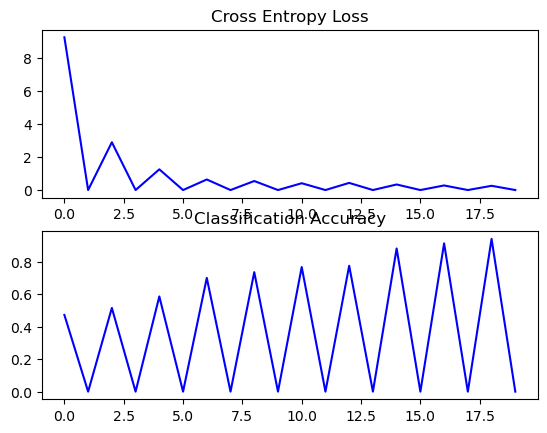

In [128]:
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.show
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')

## 5. Decrease Learning Rate + Batch Normalization

In [3]:
def define_model_dropout():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))  # Dropout rate: 25%
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.000001)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
model_d = define_model_dropout()

In [14]:
# create data generator
current_dir = os.getcwd()
datagen = ImageDataGenerator(rescale=1.0/255.0,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterators
train_it = datagen.flow_from_directory(os.path.join(current_dir, 'dataset/train'),
 class_mode='binary', batch_size=4, target_size=(200, 200))
test_it = datagen.flow_from_directory(os.path.join(current_dir, 'dataset/test'),
 class_mode='binary', batch_size=4, target_size=(200, 200))

Found 254 images belonging to 2 classes.
Found 117 images belonging to 2 classes.


In [15]:
# fit model
history = model_d.fit(
    train_it,
    steps_per_epoch=len(train_it),
    epochs=10,
    verbose=2
)

Epoch 1/10
64/64 - 46s - 720ms/step - accuracy: 0.5984 - loss: 0.7356
Epoch 2/10
64/64 - 0s - 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
64/64 - 34s - 530ms/step - accuracy: 0.6299 - loss: 0.6456
Epoch 4/10
64/64 - 0s - 297us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
64/64 - 32s - 507ms/step - accuracy: 0.6378 - loss: 0.6926
Epoch 6/10
64/64 - 0s - 563us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
64/64 - 32s - 501ms/step - accuracy: 0.6850 - loss: 0.6227
Epoch 8/10
64/64 - 0s - 297us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
64/64 - 32s - 498ms/step - accuracy: 0.6850 - loss: 0.6263
Epoch 10/10
64/64 - 0s - 187us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [141]:
# Evaluate the model using the test data generator
evaluation = model_d.evaluate(
    test_it,  # Data generator for test/validation data
    steps=len(test_it),  # Number of steps (batches) to yield from the generator
    verbose=2  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

4/4 - 16s - 4s/step - accuracy: 0.6923 - loss: 0.5746
Test Loss: 0.5745804905891418
Test Accuracy: 0.692307710647583


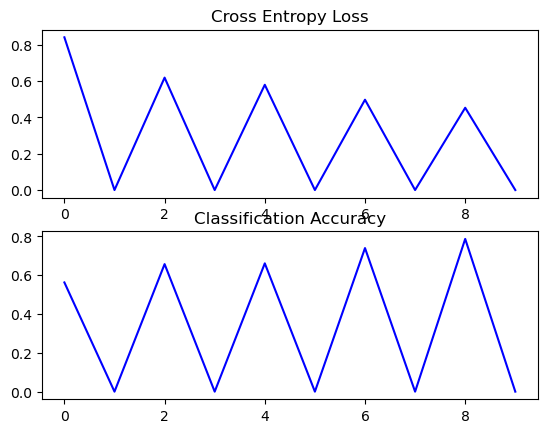

In [142]:
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.show
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')